In [12]:
!pip install numpy datasets torch tqdm

### Import the Libraries

The following Python modules will be used for our NanoGPT implementation.

In [13]:
import os
import math
import random
from dataclasses import dataclass
from typing import List, Tuple

import matplotlib.pyplot as plt

import numpy as np

from datasets import load_dataset, concatenate_datasets

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import tqdm

### Load the Dataset

In the code block below, [Open-MELON dataset](https://huggingface.co/datasets/MartiHan/Open-MELON-VL-2.5K) is loaded using HuggingFace loaders and the figure captions are concatenated into one big training corpus.


In [14]:
# ds_dict is a list of ['train', 'validation', 'test'] splits
ds_dict = load_dataset("MartiHan/Open-MELON-VL-2.5K")

# in this example, all 3 splits are concatenated
# validation set is later drawn from the text chunks of 'block_size'
ds_all = concatenate_datasets(list(ds_dict.values()))

captions = [str(x) for x in ds_all["caption"]]
print("Captions:", len(captions))
print("Example caption:", captions[0])


Captions: 2499
Example caption: Small bowel polyps showing malignant cells located at the lamina propria and submucosa. The image is stained with hematoxylin and eosin (H&E) at × 4 magnification.


#### Preprocess the Training Text

We join separate captions with `<ENDC>` separator. This helps the model learn boundaries.


In [15]:
SEP = "\n<ENDC>\n"
# SEP = " "
text = SEP.join(captions)

# Print the total number of characters in the dataset
print("Training text length (chars):", len(text))

# Print the first 1000 characters of the constructed text corpus
print(text[:1000])

Training text length (chars): 954168
Small bowel polyps showing malignant cells located at the lamina propria and submucosa. The image is stained with hematoxylin and eosin (H&E) at × 4 magnification. Histopathology of small bowel polyps showing malignant cells arranged in diffuse sheets with the presence of intracytoplasmic and extracellular pigments. The image is stained with hematoxylin and eosin (H&E) at × 20 magnification. Small bowel polyps showing malignant cells located at the lamina propria and submucosa. The image is stained with hematoxylin and eosin (H&E) at × 4 magnification. Histopathology showing spindle cell uveal melanoma from a left eye choroidal pigmented malignant melanoma, classified as invasive in the ciliary body and cornea (stage IIIB, pT4bN0M0). The microscopic examination reveals a dense cell proliferation composed of small and medium fusiform (spindle) cells, along with evident pigment production. The tissue fragments were embedded in paraffin for this histop

### Character-level Tokenizer

We build a vocabulary of unique characters from the training text.


In [16]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

# mapping of characters to numerical tokens (by their order in vocabulary alphabet)
stoi = {ch:i for i,ch in enumerate(chars)}

# mapping of numerical tokens back to characters
itos = {i:ch for i,ch in enumerate(chars)}

def encode(s: str):
    """
    Converts character to a token.
    Input: character (e.g. 'A')
    Output: numerical token (e.g. 65)
    """
    return [stoi[c] for c in s]

def decode(ids):
    """
    Converts token to a character.
    Input: numerical token (e.g. 65)
    Output: character (e.g. 'A')
    """
    return "".join(itos[i] for i in ids)

Let's print some information about the vocabulary that we have created as well as some examples of encoding words.

In [17]:
print("Size of the vocabulary:", vocab_size)
print("Preview of the vocabulary:", chars)

examples = ["male", "malignant", "melanoma", "malignant melanoma"]

print("\n--- Encoding Examples ---")

for word in examples:
    tokens = encode(word)

    # Create a visual mapping of Char -> Token
    mapping_str = ", ".join([f"'{c}':{t}" for c, t in zip(word, tokens)])

    print(f"String:  {word}")
    print(f"Tokens:  {tokens}")
    print(f"Mapping: {mapping_str}")
    print("-" * 40)


Size of the vocabulary: 108
Preview of the vocabulary: [' ', '"', '#', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', '§', '°', '±', '²', '´', 'µ', '×', 'í', 'α', 'μ', '\u2005', '\u2009', '‐', '–', '‘', '’', '“', '”', '→', '⇒', '≤', '≥', '⊷']

--- Encoding Examples ---
String:  male
Tokens:  [70, 58, 69, 62]
Mapping: 'm':70, 'a':58, 'l':69, 'e':62
----------------------------------------
String:  malignant
Tokens:  [70, 58, 69, 66, 64, 71, 58, 71, 77]
Mapping: 'm':70, 'a':58, 'l':69, 'i':66, 'g':64, 'n':71, 'a':58, 'n':71, 't':77
----------------------------------------
String:  melanoma
Tokens:  [70, 62, 69, 58, 71, 72, 70, 5

Now we encode the text corpus and store it as PyTorch array. The first 90% of this array will be used for training, while the remaining 10% will be used for validation.

In [18]:

data = torch.tensor(encode(text), dtype=torch.long)

n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split: str):
    src = train_data if split == "train" else val_data
    ix = torch.randint(len(src) - cfg.block_size - 1, (cfg.batch_size,))
    x = torch.stack([src[i:i+cfg.block_size] for i in ix])
    y = torch.stack([src[i+1:i+cfg.block_size+1] for i in ix])
    return x.to(cfg.device), y.to(cfg.device)

print("Train tokens:", train_data.numel(), "Val tokens:", val_data.numel())

Train tokens: 858751 Val tokens: 95417


### Model Training Configurations

The following configuration classes define the size of the transformer model and how it is trained. These hyperparameters control model capacity, context length, training stability, and computational cost. You can later use this to perform different experiments, e.g. comparing models of different size (capacity) and context length.

**Model configuration**

- `vocab_size` - number of unique tokens the model can process. In this assignment, tokens are individual characters, so the vocabulary size equals the number of distinct characters in the training corpus.

- `block_size` - the context window length, i.e. the maximum number of tokens the model can see at once. During training and generation, the model predicts the next token using only the previous block_size tokens. A larger block size allows the model to capture longer-range dependencies but increases memory and computation requirements.

- `n_layer` - number of stacked transformer decoder blocks. More layers increase model depth and expressiveness but also training time and risk of overfitting.

- `n_head` - number of attention heads in each self-attention layer. Multiple heads allow the model to attend to different aspects of the context simultaneously (e.g. syntax, formatting, or local patterns).

- `n_embd` - dimensionality of token embeddings and hidden representations. Larger embeddings allow richer representations but increase memory usage and compute cost.

- `dropout` - dropout probability used during training as a regularization technique. It helps prevent overfitting by randomly deactivating neurons. Dropout is disabled for CPU training to keep behavior deterministic and training stable.

**Training configuration**
- `batch_size` - Number of training sequences processed in parallel during one optimization step. Larger batches improve gradient stability but require more memory.

- `max_iters` - total number of training iterations (parameter update steps).

- `eval_interval` - number of training iterations between evaluations on the validation set.

- `eval_iters` - number of mini-batches used to estimate training and validation loss during evaluation.

- `lr (learning rate)` - step size used by the optimizer when updating model parameters. This is one of the most sensitive hyperparameters for training stability.

- `weight_decay` - regularization term that penalizes large weights and helps reduce overfitting.

- `device` - specifies whether training runs on CPU or GPU. Smaller model and batch sizes are used automatically when no GPU is available.


In [19]:
##############################################################################################
### Model configuration (number of layers, number of heads, embedding dimensions, dropout) ###
##############################################################################################

# Configuration for GPU
@dataclass
class ModelConfigGPU:
    vocab_size: int
    block_size: int
    n_layer: int = 4
    n_head: int = 4
    n_embd: int = 256
    dropout: float = 0.2

# Configuration for CPU
@dataclass
class ModelConfigCPU:
    vocab_size: int
    block_size: int
    n_layer: int = 4
    n_head: int = 4
    n_embd: int = 128
    dropout: float = 0

########################################################################################################
### Model configuration (block size, batch size, evaluation iterations, learning rate, weight decay) ###
########################################################################################################

# Configuration for GPU
@dataclass
class TrainConfigGPU:
    block_size: int = 256
    batch_size: int = 64
    max_iters: int = 2000
    eval_interval: int = 200
    eval_iters: int = 200
    lr: float = 1e-3
    weight_decay: float = 0.1
    device: str = "cuda"

# Configuration for CPU
@dataclass
class TrainConfigCPU:
    block_size: int = 64
    batch_size: int = 12
    max_iters: int = 2000
    eval_interval: int = 200
    eval_iters: int = 50
    lr: float = 1e-3
    weight_decay: float = 0.1
    device: str = "cpu"
    compile: bool = False


# Automatically select suitable configuration based on GPU detection
if torch.cuda.is_available():
  ModelConfig = ModelConfigGPU
  TrainConfig = TrainConfigGPU
else:
  ModelConfig = ModelConfigCPU
  TrainConfig = TrainConfigCPU


### Building the NanoGPT Model

The model begins with token embeddings, which map character indices to dense vectors, and positional embeddings, which encode the order of tokens within a fixed context window (`block_size`). These embeddings are added together and passed through a stack of transformer decoder blocks.

Each decoder block consists of two main submodules: causal self-attention and a feed-forward network (MLP). Causal self-attention allows each token to attend only to previous tokens by applying a causal mask, ensuring that the model cannot access future information during training or generation. Multiple attention heads are used so that the model can focus on different aspects of the context in parallel. The MLP applies a non-linear transformation independently at each position, complementing the attention mechanism. Layer normalization and residual connections are used throughout to stabilize training and preserve information flow.


In [20]:
class CausalSelfAttention(nn.Module):
    def __init__(self, c: ModelConfig):
        super().__init__()
        assert c.n_embd % c.n_head == 0
        self.n_head = c.n_head
        self.head_dim = c.n_embd // c.n_head

        self.qkv = nn.Linear(c.n_embd, 3 * c.n_embd, bias=False)
        self.proj = nn.Linear(c.n_embd, c.n_embd, bias=False)
        self.dropout = nn.Dropout(c.dropout)

        mask = torch.tril(torch.ones(c.block_size, c.block_size)).view(1, 1, c.block_size, c.block_size)
        self.register_buffer("mask", mask)

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.split(C, dim=2)

        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float("-inf"))
        att = F.softmax(att, dim=-1)
        att = self.dropout(att)

        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.proj(y)
        y = self.dropout(y)
        return y

class MLP(nn.Module):
    def __init__(self, c: ModelConfig):
        super().__init__()
        self.fc = nn.Linear(c.n_embd, 4 * c.n_embd)
        self.proj = nn.Linear(4 * c.n_embd, c.n_embd)
        self.dropout = nn.Dropout(c.dropout)

    def forward(self, x):
        x = self.fc(x)
        x = F.gelu(x)
        x = self.proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, c: ModelConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(c.n_embd)
        self.attn = CausalSelfAttention(c)
        self.ln2 = nn.LayerNorm(c.n_embd)
        self.mlp = MLP(c)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

After passing through all decoder blocks, the model applies a final layer normalization and a linear output head that produces a probability distribution over the vocabulary for the next-token prediction. The training objective is standard cross-entropy loss between the predicted next token and the true next token.

This NanoGPT model contains approximately between 0.8 and 3 million parameters, depending on the configuration. By comparison, GPT-2 contains hundreds of millions of parameters and modern commercial language models contain many billion parameters. Despite this difference in scale, the same architectural principles apply. The total number of parameters is mainly determined by the embedding dimension (`n_embd`), the number of layers (`n_layer`), and the vocabulary size, while the number of attention heads controls how the embedding space is partitioned rather than its overall size.

The model is intentionally kept small so that it can be trained quickly on limited hardware and easily inspected. The goal of this assignment is to understand how transformer components interact, not to achieve state-of-the-art language modeling performance.

In [21]:
class NanoGPT(nn.Module):
    def __init__(self, c: ModelConfig):
        super().__init__()
        self.c = c
        self.tok_emb = nn.Embedding(c.vocab_size, c.n_embd)
        self.pos_emb = nn.Embedding(c.block_size, c.n_embd)
        self.drop = nn.Dropout(c.dropout)
        self.blocks = nn.ModuleList([Block(c) for _ in range(c.n_layer)])
        self.ln_f = nn.LayerNorm(c.n_embd)
        self.head = nn.Linear(c.n_embd, c.vocab_size, bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if isinstance(module, nn.Linear) and module.bias is not None:
            nn.init.zeros_(module.bias)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        assert T <= self.c.block_size
        pos = torch.arange(0, T, device=idx.device).unsqueeze(0)

        x = self.tok_emb(idx) + self.pos_emb(pos)
        x = self.drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.ln_f(x)
        logits = self.head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

cfg = TrainConfig()
mcfg = ModelConfig(vocab_size=vocab_size, block_size=cfg.block_size)

model = NanoGPT(mcfg).to(cfg.device)
print("Parameters:", sum(p.numel() for p in model.parameters())/1e6, "M")


Parameters: 0.827136 M


### The Training Loop

We use the AdamW optimizer and periodically evaluate on the validation set. The training in Google Colab should take for both the CPU and GPU configurations approximately 4-5 minutes using the baseline configuration.

In [22]:
@torch.no_grad()
def estimate_loss():
    model.eval()
    out = {}
    for split in ["train", "val"]:
        losses = torch.zeros(cfg.eval_iters)
        for k in range(cfg.eval_iters):
            X, Y = get_batch(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean().item()
    model.train()
    return out

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

model.train()
pbar = tqdm(range(cfg.max_iters), desc="training")
for it in pbar:
    if it % cfg.eval_interval == 0:
        losses = estimate_loss()
        pbar.set_postfix(train=losses["train"], val=losses["val"])

    xb, yb = get_batch("train")
    _, loss = model(xb, yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


training:   0%|          | 0/2000 [00:00<?, ?it/s]

### Text Generation (Sampling)

Now that the model is trained we can put it to use. We generate the synthetic captions starting from `"H&E stained section showing"` string by autoregressively sampling next characters

Hyperparameters:
- `temperature`: higher = more random, lower = less variety
- `top_k`: restrict sampling to top-k most likely chars (lower number eliminates less likely candidates)

In [23]:
@torch.no_grad()
def generate(start: str, max_new_tokens=400, temperature=1.0, top_k=60):
    model.eval()
    idx = torch.tensor([encode(start)], dtype=torch.long, device=cfg.device)

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -cfg.block_size:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / max(temperature, 1e-6)

        if top_k is not None:
            v, _ = torch.topk(logits, k=min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float("Inf")

        probs = F.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_id], dim=1)

    return decode(idx[0].tolist())

prompt = "H&E stained section showing"

print(generate(prompt, max_new_tokens=500, temperature=0.7, top_k=10))


H&E stained section showing epidermota in the basitation in the infiltraton in a atypical melanocytic nevus, and higher magnification of 200X magnification of ×1, and a papillary in the epidermis of a 25 μm. Hematoxylin and Eosin (H&E) and at ×40 magnification. Histopathological findings a predominanthomatosis (the extensive and to the pigmented pathological atypical cells are and seevenitifing. The image is stained with Haematoxylin and Eosin (H&E) at ×400. Histopathological finding the pidermatocytoplasm. The image is i


In [ ]:
#code for exercise 1 (not required but we wanted to plot the losses just to make sure)
EX1_LOG_FILE = "ex1_experiments.json"

def run_ex1_experiment(sep="\n<ENDC>\n", label="baseline"):
    ex1_text = sep.join(captions)
    ex1_chars = sorted(list(set(ex1_text)))
    ex1_vs = len(ex1_chars)
    ex1_stoi = {ch: i for i, ch in enumerate(ex1_chars)}
    ex1_itos = {i: ch for i, ch in enumerate(ex1_chars)}
    ex1_encode = lambda s: [ex1_stoi[c] for c in s]
    ex1_decode = lambda ids: "".join(ex1_itos[i] for i in ids)

    ex1_data = torch.tensor(ex1_encode(ex1_text), dtype=torch.long)
    n = int(0.9 * len(ex1_data))
    ex1_train, ex1_val = ex1_data[:n], ex1_data[n:]

    ex1_mcfg = ModelConfig(vocab_size=ex1_vs, block_size=cfg.block_size)
    m = NanoGPT(ex1_mcfg).to(cfg.device)
    opt = torch.optim.AdamW(m.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    def _get_batch(split):
        src = ex1_train if split == "train" else ex1_val
        ix = torch.randint(len(src) - cfg.block_size - 1, (cfg.batch_size,))
        x = torch.stack([src[i:i+cfg.block_size] for i in ix])
        y = torch.stack([src[i+1:i+cfg.block_size+1] for i in ix])
        return x.to(cfg.device), y.to(cfg.device)

    eval_steps, train_losses, val_losses = [], [], []

    @torch.no_grad()
    def _est():
        m.eval()
        out = {}
        for sp in ["train", "val"]:
            ls = torch.zeros(cfg.eval_iters)
            for k in range(cfg.eval_iters):
                X, Y = _get_batch(sp)
                _, l = m(X, Y)
                ls[k] = l.item()
            out[sp] = ls.mean().item()
        m.train()
        return out

    m.train()
    pbar = tqdm(range(cfg.max_iters), desc=f"Ex1: {label}")
    for it in pbar:
        if it % cfg.eval_interval == 0:
            losses = _est()
            eval_steps.append(it)
            train_losses.append(losses["train"])
            val_losses.append(losses["val"])
            pbar.set_postfix(train=f"{losses['train']:.4f}", val=f"{losses['val']:.4f}")
        xb, yb = _get_batch("train")
        _, loss = m(xb, yb)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

    final = _est()
    eval_steps.append(cfg.max_iters)
    train_losses.append(final["train"])
    val_losses.append(final["val"])

    m.eval()
    idx = torch.tensor([ex1_encode("H&E stained section showing")], dtype=torch.long, device=cfg.device)
    for _ in range(500):
        idx_cond = idx[:, -cfg.block_size:]
        logits, _ = m(idx_cond)
        logits = logits[:, -1, :] / 0.7
        v, _ = torch.topk(logits, k=min(60, logits.size(-1)))
        logits[logits < v[:, [-1]]] = -float("Inf")
        probs = F.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_id], dim=1)
    generated = ex1_decode(idx[0].tolist())

    result = {
        "label": label, "sep": sep, "vocab_size": ex1_vs,
        "eval_steps": eval_steps, "train_losses": train_losses, "val_losses": val_losses,
        "final_train_loss": final["train"], "final_val_loss": final["val"],
        "generated_sample": generated,
    }

    with open(EX1_LOG_FILE, "r") as f: log = json.load(f)
    log.append(result)
    with open(EX1_LOG_FILE, "w") as f: json.dump(log, f, indent=2)
    print(f"[{label}] vocab={ex1_vs} train={final['train']:.4f} val={final['val']:.4f}")
    print(f"Sample: {generated[:200]}")
    return result

def draw_ex1_plots():
    with open(EX1_LOG_FILE, "r") as f: log = json.load(f)
    print(f"{'Label':<25} {'Vocab':<8} {'Train Loss':<12} {'Val Loss':<12}")
    for exp in log:
        print(f"{exp['label']:<25} {exp['vocab_size']:<8} {exp['final_train_loss']:<12.4f} {exp['final_val_loss']:<12.4f}")
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    colors = plt.cm.tab10.colors
    for i, exp in enumerate(log):
        c = colors[i % len(colors)]
        ax.plot(exp["eval_steps"], exp["train_losses"], color=c, linestyle="-", label=f'{exp["label"]} (train)')
        ax.plot(exp["eval_steps"], exp["val_losses"], color=c, linestyle="--", label=f'{exp["label"]} (val)')
    ax.set_xlabel("Training Iteration")
    ax.set_ylabel("Loss")
    ax.set_title("Exercise 1: Effect of Separator on Training")
    ax.legend(fontsize="small")
    plt.tight_layout()
    plt.savefig("ex1_loss_plots.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("\nGenerated Samples:")
    for exp in log:
        print(f"\n[{exp['label']}]:")
        print(exp["generated_sample"][:300])

def reproduce_ex1():
    with open(EX1_LOG_FILE, "w") as f: json.dump([], f)
    run_ex1_experiment(sep="\n<ENDC>\n", label="sep=<ENDC>")
    run_ex1_experiment(sep=" ", label='sep=" "')
    run_ex1_experiment(sep="", label='sep=""')
    draw_ex1_plots()

reproduce_ex1()

In [24]:
#exercise 2 helpers, train model and log results, and plot them

import json
import datetime
import matplotlib.pyplot as plt
from dataclasses import replace as _dc_replace

EX2_LOG_FILE = "ex2_experiments.json"

def load_ex2_log():
    with open(EX2_LOG_FILE, "r") as f:
        return json.load(f)

def save_ex2_log(log):
    with open(EX2_LOG_FILE, "w") as f:
        json.dump(log, f, indent=2)

#utilities for our own use, not for grading
def list_experiments():
    log = load_ex2_log()
    for i, exp in enumerate(log):
        hp = exp["hyperparameters"]
        print(f"  [{i}] {exp['label']:<25} train={exp['final_train_loss']:.4f}  val={exp['final_val_loss']:.4f}")

def delete_experiment(index):
    log = load_ex2_log()
    removed = log.pop(index)
    save_ex2_log(log)
    print(f"Deleted: '{removed['label']}'. Remaining: {len(log)} experiments.")

def clear_all_experiments():
    save_ex2_log([])
    print("All experiments cleared.")


def run_ex2_experiment(lr=1e-3, batch_size=12, eval_interval=200,
                       max_iters=2000, eval_iters=50, label=None):
    if label is None:
        parts = []
        if lr != 1e-3: parts.append(f"lr={lr}")
        if batch_size != 12: parts.append(f"bs={batch_size}")
        if eval_interval != 200: parts.append(f"eval_int={eval_interval}")
        label = ", ".join(parts) if parts else "baseline"

    # Local config copy , we dont change global cfg deliberately
    ecfg = _dc_replace(cfg, lr=lr, batch_size=batch_size,
                        eval_interval=eval_interval, max_iters=max_iters,
                        eval_iters=eval_iters)

    def _get_batch(split):
        src = train_data if split == "train" else val_data
        ix = torch.randint(len(src) - ecfg.block_size - 1, (ecfg.batch_size,))
        x = torch.stack([src[i:i+ecfg.block_size] for i in ix])
        y = torch.stack([src[i+1:i+ecfg.block_size+1] for i in ix])
        return x.to(ecfg.device), y.to(ecfg.device)

    fresh_model = NanoGPT(mcfg).to(ecfg.device)
    opt = torch.optim.AdamW(fresh_model.parameters(), lr=ecfg.lr, weight_decay=ecfg.weight_decay)

    eval_steps = []
    train_losses = []
    val_losses = []

    @torch.no_grad()
    def _estimate_loss():
        fresh_model.eval()
        out = {}
        for split in ["train", "val"]:
            losses_t = torch.zeros(ecfg.eval_iters)
            for k in range(ecfg.eval_iters):
                X, Y = _get_batch(split)
                _, l = fresh_model(X, Y)
                losses_t[k] = l.item()
            out[split] = losses_t.mean().item()
        fresh_model.train()
        return out

    fresh_model.train()
    pbar = tqdm(range(ecfg.max_iters), desc=f"Ex2: {label}")
    for it in pbar:
        if it % ecfg.eval_interval == 0:
            losses = _estimate_loss()
            eval_steps.append(it)
            train_losses.append(losses["train"])
            val_losses.append(losses["val"])
            pbar.set_postfix(train=f"{losses['train']:.4f}", val=f"{losses['val']:.4f}")

        xb, yb = _get_batch("train")
        _, loss = fresh_model(xb, yb)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

    final = _estimate_loss()
    eval_steps.append(ecfg.max_iters)
    train_losses.append(final["train"])
    val_losses.append(final["val"])

    result = {
        "label": label,
        "timestamp": datetime.datetime.now().isoformat(),
        "hyperparameters": {
            "lr": lr,
            "batch_size": batch_size,
            "eval_interval": eval_interval,
            "max_iters": max_iters,
            "eval_iters": eval_iters,
        },
        "eval_steps": eval_steps,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "final_train_loss": final["train"],
        "final_val_loss": final["val"],
    }

    log = load_ex2_log()
    log.append(result)
    save_ex2_log(log)

    return result



def draw_plots(log_file=""):
    if log_file:
        with open(log_file, "r") as f:
            log = json.load(f)
    else:
        log = load_ex2_log()
    if not log:
        print("No experiments logged yet")
    else:
        print(f"{'Label':<25} {'LR':<10} {'BS':<6} {'Eval Int':<10} {'Train Loss':<12} {'Val Loss':<12}")
        for exp in log:
            hp = exp["hyperparameters"]
            print(f"{exp['label']:<25} {hp['lr']:<10} {hp['batch_size']:<6} "
                f"{hp['eval_interval']:<10} {exp['final_train_loss']:<12.4f} {exp['final_val_loss']:<12.4f}")

        def categorize(exp):
            hp = exp["hyperparameters"]
            cats = []
            if hp["lr"] != 1e-3 or exp["label"] == "baseline": cats.append("learning_rate")
            if hp["batch_size"] != 12 or exp["label"] == "baseline": cats.append("batch_size")
            if hp["eval_interval"] != 200 or exp["label"] == "baseline": cats.append("eval_interval")
            if not cats: cats = ["other"]
            return cats

        groups = {"learning_rate": [], "batch_size": [], "eval_interval": [], "other": []}
        for exp in log:
            for cat in categorize(exp):
                if cat in groups:
                    groups[cat].append(exp)

        groups = {k: v for k, v in groups.items() if v}

        fig, axes = plt.subplots(1, len(groups), figsize=(7 * len(groups), 5), squeeze=False)

        colors = plt.cm.tab10.colors
        group_titles = {
            "learning_rate": "Effect of Learning Rate",
            "batch_size": "Effect of Batch Size",
            "eval_interval": "Effect of Evaluation Interval",
        }

        for ax_idx, (group_name, exps) in enumerate(groups.items()):
            ax = axes[0][ax_idx]
            for i, exp in enumerate(exps):
                c = colors[i % len(colors)]
                ax.plot(exp["eval_steps"], exp["train_losses"],
                        color=c, linestyle="-", label=f'{exp["label"]} (train)')
                ax.plot(exp["eval_steps"], exp["val_losses"],
                        color=c, linestyle="--", label=f'{exp["label"]} (val)')
            ax.set_xlabel("Training Iteration")
            ax.set_ylabel("Loss")
            ax.set_title(group_titles.get(group_name, group_name))
            ax.legend(fontsize="small")
        plt.tight_layout()
        save_name = os.path.splitext(log_file)[0] + ".png" if log_file else "ex2_loss_plots.png"
        plt.savefig(save_name, dpi=150, bbox_inches="tight")
        plt.show()
        print(f"Plot saved to {save_name}")

Exercise 2 experiment runs

In [ ]:

#two blocks of experiment calls for demonstrating average changes and extreme changes for exercise 2

def reproduce_average_changes():
    clear_all_experiments()
    run_ex2_experiment() #1. baseline
    #average changes:
    run_ex2_experiment(lr=1e-4, label="lr=1e-4 (low)") # 2. Low learning rate
    run_ex2_experiment(lr=1e-2, label="lr=1e-2 (high)") # 3. High learning rate
    run_ex2_experiment(batch_size=4, label="bs=4 (small)") # 4. Small batch size
    run_ex2_experiment(batch_size=32, label="bs=32 (large)") # 5. Large batch size
    run_ex2_experiment(eval_interval=50, label="eval_int=50 (freq)") # 6. Frequent eval
    run_ex2_experiment(eval_interval=500, label="eval_int=500 (rare)") # 7. Rare eval
    draw_plots()

def reproduce_extreme_changes():
    clear_all_experiments()
    run_ex2_experiment()
    #extreme changes:
    run_ex2_experiment(lr=1e-5, label="lr=1e-5 (very low)") # 2. Very low learning rate
    run_ex2_experiment(lr=5e-2, label="lr=5e-2 (very high)") # 3. Very high learning rate
    run_ex2_experiment(batch_size=2, label="bs=2 (tiny)") # 4. Tiny batch size
    run_ex2_experiment(batch_size=64, label="bs=64 (very large)") # 5. Very large batch size
    run_ex2_experiment(eval_interval=25, label="eval_int=25 (freq)") # 6. Very frequent eval
    run_ex2_experiment(eval_interval=1000, label="eval_int=1000 (rare)") # 7. Very rare eval
    draw_plots()


reproduce_average_changes() # call this if you want to reproduce our experiments

All ex3 experiments cleared.


Ex3: both (baseline):   0%|          | 0/2000 [00:00<?, ?it/s]

All ex3 experiments cleared.


Ex3: both (baseline):   0%|          | 0/2000 [00:00<?, ?it/s]

[both (baseline)] vocab=108 train=1.0547 val=1.1631
Sample: H&E stained section showing moderate. The eassed of tucout cells with bructatter butek. Character dermis. Haus distintis as as eosinophilic ch tumor irrhagin the lymphocytic inflammatory strea. Areasi


Ex3: lowercase:   0%|          | 0/2000 [00:00<?, ?it/s]

All ex3 experiments cleared.


Ex3: both (baseline):   0%|          | 0/2000 [00:00<?, ?it/s]

[both (baseline)] vocab=108 train=1.0547 val=1.1631
Sample: H&E stained section showing moderate. The eassed of tucout cells with bructatter butek. Character dermis. Haus distintis as as eosinophilic ch tumor irrhagin the lymphocytic inflammatory strea. Areasi


Ex3: lowercase:   0%|          | 0/2000 [00:00<?, ?it/s]

[lowercase] vocab=82 train=1.0856 val=1.1430
Sample: h&e stained section showing was a distibuterfitinclumelamous termbedderetined it the ra 6-ya or of by thistopathological melanoma, markound to fost suggineds. the image is characted formatotic ircuded


Ex3: uppercase:   0%|          | 0/2000 [00:00<?, ?it/s]

All ex3 experiments cleared.


Ex3: both (baseline):   0%|          | 0/2000 [00:00<?, ?it/s]

[both (baseline)] vocab=108 train=1.0547 val=1.1631
Sample: H&E stained section showing moderate. The eassed of tucout cells with bructatter butek. Character dermis. Haus distintis as as eosinophilic ch tumor irrhagin the lymphocytic inflammatory strea. Areasi


Ex3: lowercase:   0%|          | 0/2000 [00:00<?, ?it/s]

[lowercase] vocab=82 train=1.0856 val=1.1430
Sample: h&e stained section showing was a distibuterfitinclumelamous termbedderetined it the ra 6-ya or of by thistopathological melanoma, markound to fost suggineds. the image is characted formatotic ircuded


Ex3: uppercase:   0%|          | 0/2000 [00:00<?, ?it/s]

[uppercase] vocab=81 train=1.0841 val=1.1874
Sample: H&E STAINED SECTION SHOWING A PROGID A DENOCRINE OF THE IN A PEVERAL AYRE ARRISTIC OF THE NEVUS MALE PESITCULAR SEMBENTATION A 4103.M IS POWTOMORPHISM. HISTOPATHOLOGY, SHOWING A TROUND NODULE MULTINE 
Label                     Case     Vocab    Train Loss   Val Loss    
both (baseline)           both     108      1.0547       1.1631      
lowercase                 lower    82       1.0856       1.1430      
uppercase                 upper    81       1.0841       1.1874      


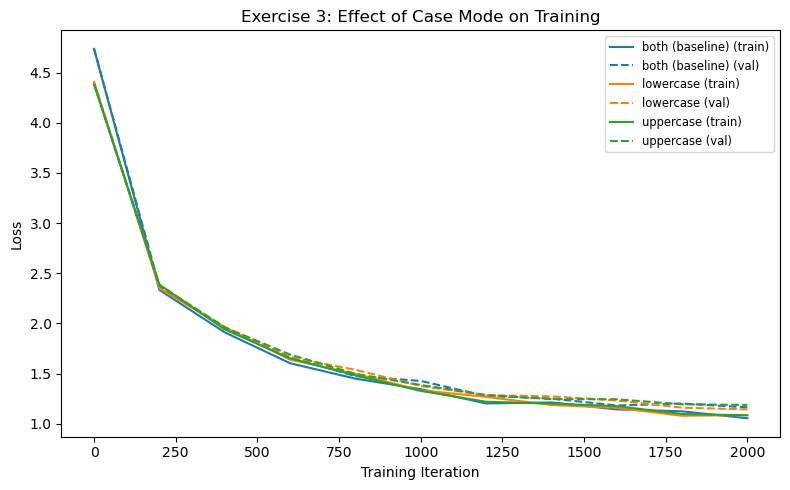

Plot saved to ex3_loss_plots.png

 Generated Samples

[both (baseline)]:
H&E stained section showing moderate. The eassed of tucout cells with bructatter butek. Character dermis. Haus distintis as as eosinophilic ch tumor irrhagin the lymphocytic inflammatory strea. Areasiving the histopathology ilike with atypical cells, sust a gircoscncoment is an with feature oreticin

[lowercase]:
h&e stained section showing was a distibuterfitinclumelamous termbedderetined it the ra 6-ya or of by thistopathological melanoma, markound to fost suggineds. the image is characted formatotic ircuded spr‘tin (hc) of collagensative large prineural-de), and mordule invased at imorma-blame, nevus, a b

[uppercase]:
H&E STAINED SECTION SHOWING A PROGID A DENOCRINE OF THE IN A PEVERAL AYRE ARRISTIC OF THE NEVUS MALE PESITCULAR SEMBENTATION A 4103.M IS POWTOMORPHISM. HISTOPATHOLOGY, SHOWING A TROUND NODULE MULTINE WITH A COLLAGENOUS CHARACTLY TKERATIC ASYTIC SYRINGTUICALLY MELANOMA, SHOWING FIBRINGS OF THE NES

In [33]:
#exercise 3
EX3_LOG_FILE = "ex3_experiments.json"

def preprocessed_text(text, case_mode="both"):
    if case_mode == "lower":
        return text.lower()
    elif case_mode == "upper":
        return text.upper()
    return text

def load_ex3_log():
    with open(EX3_LOG_FILE, "r") as f:
        return json.load(f)


def save_ex3_log(log):
    with open(EX3_LOG_FILE, "w") as f:
        json.dump(log, f, indent=2)

def list_ex3_experiments():
    log = load_ex3_log()
    for i, exp in enumerate(log):
        print(f"  [{i}] {exp['label']:<25} train={exp['final_train_loss']:.4f}  val={exp['final_val_loss']:.4f}")

def clear_all_ex3_experiments():
    save_ex3_log([])
    print("All ex3 experiments cleared.")


def run_ex3_experiment(case_mode="both", label=None):
    if label is None:
        label = f"case={case_mode}"

    ex3_text = preprocessed_text(SEP.join(captions), case_mode)
    ex3_chars = sorted(list(set(ex3_text)))
    ex3_vocab_size = len(ex3_chars)
    ex3_stoi = {ch: i for i, ch in enumerate(ex3_chars)}
    ex3_itos = {i: ch for i, ch in enumerate(ex3_chars)}
    ex3_encode = lambda s: [ex3_stoi[c] for c in s]
    ex3_decode = lambda ids: "".join(ex3_itos[i] for i in ids)

    ex3_data = torch.tensor(ex3_encode(ex3_text), dtype=torch.long)
    n = int(0.9 * len(ex3_data))
    ex3_train = ex3_data[:n]
    ex3_val = ex3_data[n:]

    ex3_mcfg = ModelConfig(vocab_size=ex3_vocab_size, block_size=cfg.block_size)
    fresh_model = NanoGPT(ex3_mcfg).to(cfg.device)
    opt = torch.optim.AdamW(fresh_model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    def _get_batch(split):
        src = ex3_train if split == "train" else ex3_val
        ix = torch.randint(len(src) - cfg.block_size - 1, (cfg.batch_size,))
        x = torch.stack([src[i:i+cfg.block_size] for i in ix])
        y = torch.stack([src[i+1:i+cfg.block_size+1] for i in ix])
        return x.to(cfg.device), y.to(cfg.device)

    eval_steps = []
    train_losses = []
    val_losses = []

    @torch.no_grad()
    def _estimate_loss():
        fresh_model.eval()
        out = {}
        for split in ["train", "val"]:
            losses_t = torch.zeros(cfg.eval_iters)
            for k in range(cfg.eval_iters):
                X, Y = _get_batch(split)
                _, l = fresh_model(X, Y)
                losses_t[k] = l.item()
            out[split] = losses_t.mean().item()
        fresh_model.train()
        return out

    fresh_model.train()
    pbar = tqdm(range(cfg.max_iters), desc=f"Ex3: {label}")
    for it in pbar:
        if it % cfg.eval_interval == 0:
            losses = _estimate_loss()
            eval_steps.append(it)
            train_losses.append(losses["train"])
            val_losses.append(losses["val"])
            pbar.set_postfix(train=f"{losses['train']:.4f}", val=f"{losses['val']:.4f}")

        xb, yb = _get_batch("train")
        _, loss = fresh_model(xb, yb)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

    final = _estimate_loss()
    eval_steps.append(cfg.max_iters)
    train_losses.append(final["train"])
    val_losses.append(final["val"])

    prompt_raw = "H&E stained section showing"
    prompt = preprocessed_text(prompt_raw, case_mode)

    fresh_model.eval()
    idx = torch.tensor([ex3_encode(prompt)], dtype=torch.long, device=cfg.device)
    temperature = 1.0
    top_k = 60
    for _ in range(500):
        idx_cond = idx[:, -cfg.block_size:]
        logits, _ = fresh_model(idx_cond)
        logits = logits[:, -1, :] / max(temperature, 1e-6)
        if top_k is not None:
            v, _ = torch.topk(logits, k=min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float("Inf")
        probs = F.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_id], dim=1)
    generated = ex3_decode(idx[0].tolist())

    result = {
        "label": label,
        "timestamp": datetime.datetime.now().isoformat(),
        "case_mode": case_mode,
        "vocab_size": ex3_vocab_size,
        "eval_steps": eval_steps,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "final_train_loss": final["train"],
        "final_val_loss": final["val"],
        "generated_sample": generated,
    }

    log = load_ex3_log()
    log.append(result)
    save_ex3_log(log)
    print(f"[{label}] vocab={ex3_vocab_size} train={final['train']:.4f} val={final['val']:.4f}")
    print(f"Sample: {generated[:200]}")

    return result


def draw_ex3_plots(log_file=""):
    if log_file:
        with open(log_file, "r") as f:
            log = json.load(f)
    else:
        log = load_ex3_log()
    if not log:
        print("No ex3 experiments logged yet")
        return

    print(f"{'Label':<25} {'Case':<8} {'Vocab':<8} {'Train Loss':<12} {'Val Loss':<12}")
    for exp in log:
        print(f"{exp['label']:<25} {exp['case_mode']:<8} {exp['vocab_size']:<8} "
              f"{exp['final_train_loss']:<12.4f} {exp['final_val_loss']:<12.4f}")

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    colors = plt.cm.tab10.colors
    for i, exp in enumerate(log):
        c = colors[i % len(colors)]
        ax.plot(exp["eval_steps"], exp["train_losses"],
                color=c, linestyle="-", label=f'{exp["label"]} (train)')
        ax.plot(exp["eval_steps"], exp["val_losses"],
                color=c, linestyle="--", label=f'{exp["label"]} (val)')
    ax.set_xlabel("Training Iteration")
    ax.set_ylabel("Loss")
    ax.set_title("Exercise 3: Effect of Case Mode on Training")
    ax.legend(fontsize="small")
    plt.tight_layout()
    save_name = os.path.splitext(log_file)[0] + ".png" if log_file else "ex3_loss_plots.png"
    plt.savefig(save_name, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Plot saved to {save_name}")

    print("\n Generated Samples")
    for exp in log:
        print(f"\n[{exp['label']}]:")
        print(exp["generated_sample"][:300])


def reproduce_ex3():
    clear_all_ex3_experiments()
    run_ex3_experiment(case_mode="both", label="both (baseline)")
    run_ex3_experiment(case_mode="lower", label="lowercase")
    run_ex3_experiment(case_mode="upper", label="uppercase")
    draw_ex3_plots()

reproduce_ex3()

Exercise 5 code can be found below:

In [27]:
def run_ex5(prompt, list_of_temperature = [1,0,10], list_of_top_k = [60,1]):
  for i in range(len(list_of_temperature)):
    print(f"here stats a new generated prompt with temperature = {list_of_temperature[i]} and top_k = {list_of_top_k[0]}")
    print(generate(prompt, max_new_tokens=500, temperature=list_of_temperature[i], top_k=list_of_top_k[0]))
    print()
  for i in range(len(list_of_top_k)):
    print(f"here starts a newly generated prompt with temperature = {list_of_temperature[0]} and top_k = {list_of_top_k[i]}")
    print(generate(prompt, max_new_tokens=500, temperature=list_of_temperature[0], top_k=list_of_top_k[i]))
    print()
#run_ex5(prompt)
run_ex5(prompt,[0.4,0.5,0.75],[60,30])

here stats a new generated prompt with temperature = 0.4 and top_k = 60
H&E stained section showing a component of the responding the tumor melanoma (SL) of the paredominantly and eye of the patient and a dermis. The image is shows a predominantly pigmented nests and subcution of the surrroscomastic tumounted tumor a of a 2000x magnification. Histopathology of a image of stained with Hematoxylin and Eosin (H&E) at × 2000x magnification. Histopathology of a tumor cell cells with a predominantly continal patient with a subcutaneous and patient in the semetastating a dermis and a predomination t

here stats a new generated prompt with temperature = 0.5 and top_k = 60
H&E stained section showing a betwen as epithelioid a minated spindle cell cells and the subcuted in the nevus predominantly the dermis. This a a predominantly a dermal distinct multinucleation infiltration a porifature and in the epithelium and capt large at the dermis, are tumor stained with Hematoxylin and Eosin (H&E). His

⚠️ *Everything below this line must be submitted as a deliverable for this assignment.*

ℹ️ *Answering the exercises below will require you to implement new code and/or modify the code in cells above. You can add the code directly in the notebook or in separate Python files, depending on your preference. If you write code in separate files, please do not forget to also submit them. The exercises will also require re-running the training, sometimes multiple times. You can split the workload among the group members so things are done more efficiently.*

## Exercises: Practice

#### Exercise 1

When we created the text corpus, we used the `<ENDC>` separator to mark the end of a caption. Why is the `<ENDC>` separator needed? What would happen if you use a model trained without such separator in practice? In order to investigate this, train a model without the `<ENDC>` separator and compare the results with the model trained with the `<ENDC>` separator when generating captions.

Output with the `<ENDC>` separator (```SEP = "\n<ENDC>\n"```):
```
H&E stained section showing a displays and an and solites the stromal perimary incouse and in subtased and plominant this stained with Hematoxylin and Eosin (H&E) (H&E) stain, 100X).
<ENDC>
Histopathology of atypical magnification of ocular small, shower can man for significant melanocytes, stained with Hematoxylin and Eosin (H&E) stainification ×100)
<ENDC>
Histopathological showing and a proliferating of a matures. The image shows epithelial connece of the cellulcination of and considures. The image displays considuct n
```
Output with " " as seperator (```SEP = " "```):
```
H&E stained section showing epidermota in the basitation in the infiltraton in a atypical melanocytic nevus, and higher magnification of 200X magnification of ×1, and a papillary in the epidermis of a 25 μm. Hematoxylin and Eosin (H&E) and at ×40 magnification. Histopathological findings a predominanthomatosis (the extensive and to the pigmented pathological atypical cells are and seevenitifing. The image is stained with Haematoxylin and Eosin (H&E) at ×400. Histopathological finding the pidermatocytoplasm. The image is i
```

Output with "" as seperator (```SEP = ""```):
```
H&E stained section showing a shapeact of a sollagen with in the diagnosis of the dermal presenting intraepitheling siver present with intradermal lesion from a presenting at marganul case and as of phistior and nodullation, characterized by andell-shared arrow cells and are tumor cells arrows. This component in a and arrow an extendings of a celles and and sellow his arring in the dermal epithelioid and sugfivastent with a malignant nevolying a pigmentation of shiver biopsy from a presenting at malignant melanoma showing
```

To reproduce, run `reproduce_ex1()`. Training losses are nearly identical across all three configurations:

| Separator | Vocab Size | Train Loss | Val Loss |
|:---|:---|:---|:---|
| `\n<ENDC>\n` | 109 | 1.0485 | 1.1492 |
| `" "` | 108 | 1.1075 | 1.1691 |
| `""` | 108 | 1.0840 | 1.1488 |

Analysis: The separator choice has negligible effect on loss because `<ENDC>` tokens represent a tiny fraction of the 970K character corpus. The real purpose of `<ENDC>` is not to improve loss but to provide an unambiguous boundary during generation. Since `<ENDC>` introduces a unique multi-character pattern (`<`, `E`, `N`, `D`, `C`, `>`) that never appears inside any caption, the model learns to associate it with caption termination. This means in practice it can serve as a stopping criterion: generation halts when the model emits `<ENDC>`, producing a single caption. With `" "` as separator, the boundary signal is lost because spaces already appear within captions, so the model cannot distinguish an inter-caption boundary from a normal word break. With `""` (no separator), captions are simply concatenated directly with nothing between them, so no boundary signal exists at all. In the training data this creates spaceless joins like `...magnification.Histopathology of...`, but these roughly 2,500 boundary points are less than 0.3% of the total 970K character corpus, so the model still overwhelmingly learns normal spaced text and rarely reproduces these glued artifacts during generation. In both cases, generation produces one continuous stream that drifts across topics without ever cleanly ending, making it impossible to extract individual captions. As visible in the generated samples above, the `<ENDC>` model segments its output into distinct captions that each start fresh, while the models without separator produce one paragraph blending multiple topics together.

#### Exercise 2

Train the model and plot training loss and validation loss as a function of training iterations. Modify the following hyperparameters and observe the effect:
- Learning rate
- Batch size
- Evaluation interval

Explain why the observed changes occur. What patterns indicate underfitting? What patterns suggest overfitting or unstable training?

**Answer**:

### Exercise 2 Analysis

We ran 12 main experiments: a baseline plus 6 variations with moderate ("average") changes, and a baseline plus 6 variations with extreme changes. To reproduce the experiments, run `reproduce_average_changes()` and `reproduce_extreme_changes()`.


#### Effect of Learning Rate

The loss curves for the moderate learning rate experiments are shown in [Figure 1](#fig-lr-average), and the extreme learning rate experiments in [Figure 2](#fig-lr-extreme). The learning rate sets the speed of convergence.

<a id="fig-lr-average"></a>

![Figure 1: Effect of Learning Rate, average experiments](https://raw.githubusercontent.com/helloimdomas/team5-medical-ai/main/assignments/task1deliverables/ex2_experiments-average_learning_rate.png)

*Figure 1: Loss curves for moderate learning rate variations (lr=1e-4, baseline 1e-3, lr=1e-2).*

<a id="fig-lr-extreme"></a>

![Figure 2: Effect of Learning Rate, extreme experiments](https://raw.githubusercontent.com/helloimdomas/team5-medical-ai/main/assignments/task1deliverables/ex2_experiments-extreme_learning_rate.png)

*Figure 2: Loss curves for extreme learning rate variations (lr=1e-5, baseline 1e-3, lr=5e-2).*

- Low learning rate (1e-4): The optimizer takes very small steps, so the model learns slowly. After 2000 iterations the loss is still high (val=1.46 vs. baseline 1.12), indicating the model has not yet converged. Given more iterations, it would likely eventually reach a similar loss, but within this fixed budget it appears undertrained. This is underfitting, but not in the classical sense. Here the model has sufficient capacity, it simply hasn't had enough effective optimization steps.

- High learning rate (1e-2): The optimizer takes overly large steps, causing it to overshoot minima. The loss curve shows instability because the loss occasionally rises before descending again (e.g. from 2.30 at iter 1400 back up to 2.33 at iter 1600), as visible in [Figure 1](#fig-lr-average). The final loss (val=2.04) is worse than even the low learning rate, because the large steps prevent the optimizer from settling into a good region of the loss landscape. This is unstable training..

The extreme parameter experiments confirm these patterns more dramatically (see [Figure 2](#fig-lr-extreme)):
- lr=1e-5: Severe underfitting (undertraining), the loss barely decreases from its initial value (val=2.71), because the tiny step size means the model has made almost no meaningful progress in 2000 iterations.
- lr=5e-2: Clear divergence (opposite of convergence). The loss oscillates heavily throughout training (e.g. dropping to 2.71 at iter 1600, then rising back up to 3.04 at iter 2000). The optimizer never converges, it repeatedly overshoots the minima and the loss actually increases toward the end.

Conclusion:
The baseline learning rate of 1e-3 is pretty well tuned for this model and dataset. Too low learning rates cause slow convergence (the model can't make enough progress within the iteration budget), while too high learning rates cause optimization instability. The optimal learning rate depends on the specific interaction between the optimizer (in this case, AdamW maintains moving averages of gradients), the loss landscape shape, and the gradient magnitudes so it cannot be derived analytically, by simple calculations, and must be found empirically.

To further demonstrate that the learning rate just affects the speed of convergence, we extended the training to 6000 iterations (3x the default budget) for both the baseline (`lr=1e-3`) and the low learning rate (`lr=1e-4`). With 6000 iterations, `lr=1e-4` reached train=0.9916 and val=1.0926, lower than the baseline at 2000 iterations (train~1.05, val~1.12), confirming that the model was indeed just undertrained and continued to improve given more time. However, the baseline `lr=1e-3` at 6000 iterations reached train=0.8085 and val=0.9532, which is substantially lower still. This shows that even with 3x more iterations, the lower learning rate cannot catch up to the default, and the optimizer's small step size remains a bottleneck, leaving the model underfitted relative to what the same architecture can achieve with a better tuned learning rate. On the other hand, with this many iterations, both learning rates show overfitting, the gap between train and val losses starts to widen.

<a id="fig-lr-6000"></a>

![Figure 3: Effect of Learning Rate, 6000 iterations](https://raw.githubusercontent.com/helloimdomas/team5-medical-ai/main/assignments/task1deliverables/6000iters.png)

*Figure 3: Loss curves for baseline (lr=1e-3) vs. low learning rate (lr=1e-4) over 6000 iterations.*


#### Effect of Batch Size

Larger batch sizes led to lower final losses, while smaller batch sizes led to higher losses (underfitting). The average batch size experiments are shown in [Figure 4](#fig-bs-average), and the extreme experiments in [Figure 5](#fig-bs-extreme).

- bs=32: Final val loss = 0.97, significantly better than the baseline (1.12).
- bs=4: Final val loss = 1.48, significantly worse.

This effect is primarily explained by how much data the model sees in a fixed number of iterations. Each iteration, `get_batch` constructs a tensor of shape `(batch_size, block_size)`, that is, `batch_size` sequences of `block_size` consecutive tokens each. The `block_size` (64 on CPU) is the model's context window: the maximum number of tokens the model can see at once when predicting the next token. So each iteration processes `batch_size x block_size` tokens in total.

With a fixed budget of `max_iters = 2000`:

$$\text{Tokens per iteration} = \text{batch size} \times \text{block size}$$
$$\text{Total tokens seen} = \text{batch size} \times \text{block size} \times \text{max iters}$$

The full encoded corpus has ~971,654 characters (= tokens, since we use character level tokenization). After the 90/10 train/val split: `train_tokens = floor(0.9 x 971,654) = 874,488`. One epoch means the model has seen this many tokens in total.

$$\text{Estimated epochs} = \frac{\text{batch size} \times \text{block size} \times \text{max iters}}{\text{train tokens}} = \frac{\text{batch size} \times 64 \times 2000}{874{,}488}$$

Example for the baseline (`bs=12`):
- Tokens/iteration: 12 x 64 = 768
- Total tokens seen: 768 x 2000 = 1,536,000
- Estimated epochs: 1,536,000 / 874,488 = 1.76

With `bs=32`, the model effectively trains for ~4.7 epochs vs. ~1.8 for the baseline. It sees the dataset roughly 2.7 times more, which could explain the better performance. Additionally, larger batches produce more stable gradient estimates (less noise per update), which helps the AdamW optimizer make more consistent progress.

With `bs=4`, the model sees less than one full epoch of data, meaning it has not even seen every training example once. The noisy small batch gradients also make optimization less efficient.

The extreme experiments reinforce this (see [Figure 5](#fig-bs-extreme)):
- bs=64: Best result overall (val=0.93), ~9.4 epochs of data exposure. However, we also observe a growing gap between train loss (0.75) and val loss (0.93), which is also a sign of overfitting.
- bs=2: Worst batch size result (val=1.86), with the model seeing only ~29% of the training data.

<a id="fig-bs-average"></a>

![Figure 4: Effect of Batch Size, average experiments](https://raw.githubusercontent.com/helloimdomas/team5-medical-ai/main/assignments/task1deliverables/ex2_experiments-average_batch_size.png)

*Figure 4: Loss curves for moderate batch size variations (bs=4, baseline 12, bs=32).*

<a id="fig-bs-extreme"></a>

![Figure 5: Effect of Batch Size, extreme experiments](https://raw.githubusercontent.com/helloimdomas/team5-medical-ai/main/assignments/task1deliverables/ex2_experiments-extreme_batch_size.png)

*Figure 5: Loss curves for extreme batch size variations (bs=2, baseline 12, bs=64).*

Conclusion: Within a fixed iteration budget, larger batch sizes are beneficial because the model sees more data. However, very large batch sizes can lead to overfitting, as seen in the widening gap for bs=64.



#### Effect of Evaluation Interval

The evaluation interval does not affect training, it only changes how frequently we pause to estimate the loss. The model's parameter updates are identical regardless of how often we evaluate. This is confirmed by the nearly identical final losses across all evaluation intervals:

| Eval Interval | Final Train Loss | Final Val Loss |
|:---|:---|:---|
| 25 (very freq) | 1.028 | 1.141 |
| 50 (freq) | 1.057 | 1.185 |
| 200 (baseline) | 1.053 | 1.116 |
| 500 (rare) | 1.054 | 1.166 |
| 1000 (very rare) | 1.075 | 1.143 |

The small differences between runs are due to random initialization, each experiment trains a fresh model with different random weights, so no two runs are exactly identical even with the same hyperparameters.

The "training loss" plotted is not the batch loss at each step. It is an estimate computed by `_estimate_loss()`, which averages over 50 random batches at each evaluation point. With `eval_interval=25`, we compute this estimate 80 times during training, producing a densely sampled (and noisier looking) curve. With `eval_interval=1000`, we compute it only twice (plus the final evaluation), producing a straight line between just 3 points. The underlying training trajectory is the same and we observe it at different resolutions, as shown in [Figure 6](#fig-eval-average) and [Figure 7](#fig-eval-extreme).

<a id="fig-eval-average"></a>

![Figure 6: Effect of Evaluation Interval, average experiments](https://raw.githubusercontent.com/helloimdomas/team5-medical-ai/main/assignments/task1deliverables/ex2_experiments-average_eval_interval.png)

*Figure 6: Loss curves for moderate eval interval variations (25, 50, baseline 200, 500).*

<a id="fig-eval-extreme"></a>

![Figure 7: Effect of Evaluation Interval, extreme experiments](https://raw.githubusercontent.com/helloimdomas/team5-medical-ai/main/assignments/task1deliverables/ex2_experiments-extreme_eval_interval.png)

*Figure 7: Loss curves for extreme eval interval variations (25, baseline 200, 1000).*

While the eval interval does not affect the model's final quality, it does affect total training time. Each evaluation call runs `_estimate_loss()`, which performs `2 x eval_iters = 100` extra forward passes (50 per split) with `@torch.no_grad()`. These passes do not update the model but still take time. With `max_iters=2000`, the overhead scales directly with the number of evaluations.

Setting `eval_interval=25` produces 40x more evaluation overhead than `eval_interval=1000`. On CPU, each `_estimate_loss()` call is nontrivial, so very frequent evaluation noticeably slows down the total run.

Conclusion: More frequent evaluation does not improve the model. Less frequent evaluation trains faster, but provides less visibility into the learning dynamics (loss curves). The figures confirm that differing eval intervals produce identical training trajectories sampled at different resolutions.


#### Overfitting and Underfitting

- Underfitting is indicated by high train and val loss, the model has not learned enough. This was observed with low learning rates ([Figure 1](#fig-lr-average), [Figure 2](#fig-lr-extreme)) and small batch sizes ([Figure 4](#fig-bs-average), [Figure 5](#fig-bs-extreme)).
- Overfitting is indicated by a gap between low train loss and higher val loss when the model memorizes training data. Early signs of this were visible with bs=64 (train=0.75, val=0.93, gap=0.18) compared to the baseline (train=1.05, val=1.12, gap=0.07), as shown in [Figure 5](#fig-bs-extreme).
- Unstable training is indicated by oscillating loss curves (loss climbing back up). This was observed with high learning rates (lr=1e-2 and especially lr=5e-2), visible in [Figure 1](#fig-lr-average) and [Figure 2](#fig-lr-extreme).

#### Exercise 3

We can reduce the number of tokens by converting all letters to either uppercase or lowercase. Implement this in the preprocessing function and retrain a model. Report your observations on the training and performance of the model.

**Answer**:

*A function (preprocessed_text) is added where can be put in whether the given text should be considered with only lowercase, uppercase or both. The model will then adapt to the right vocabulary size. When trained with lowercase, uppercase and both, the results of the training and validation loss plots seem identical. This is because the datasets barely change due to the fact that there is a little amount of uppercase letters, relative to the total amount of tokens in the given captions. When trained with both lower- and uppercase, the model has to learn the difference between 'The' and 'the'. It also has to take both upper- and lowercase tokens into account when assigning probability. So when the vocabulary is made smaller, the Softmax layer has fewer "choices" to make. So, by removing differences the probability is more compact. However, the vocabulary reduction is small so there is no faster drop in training loss seen. *

| Label | Case | Vocab | Train Loss | Val Loss |
|:---|:---|:---|:---|:---|
| both (baseline) | both | 109 | 0.8744 | 0.9848 |
| lowercase | lower | 83 | 0.8683 | 0.9481 |
| uppercase | upper | 82 | 0.8558 | 0.9501 |

To reproduce, run `reproduce_ex3()`.

![Figure 8: Effect of Case Mode on Training](https://github.com/helloimdomas/team5-medical-ai/blob/main/assignments/task1deliverables/ex3.png?raw=true)

*Figure 8: Loss curves for case mode variations (both, lowercase, uppercase).*

#### Exercise 4

The dataset contains 2500 figure captions. After encoding and splitting out 10% of the tokens for validation, we are left with 874488 training tokens. Is this also the number of training samples used to train our NanoGPT model? If yes, explain why, if not try to estimate the actual number of training samples.

**Answer**:

*No, 874,488 is the number of training tokens, not the number of training samples. In the source code, the `get_batch` function randomly samples `batch_size` starting indices via `torch.randint(len(src) - cfg.block_size - 1, (cfg.batch_size,))` and constructs `batch_size` sequences of length `block_size` as input and target pairs. Each such sequence is one training sample. The training loop calls `get_batch("train")` once per iteration, so the model processes `batch_size` samples per iteration.*

*The total number of training samples is therefore:*

$$\text{Total samples} = \text{max_iters} \times \text{batch_size}$$

*Using the CPU configuration from the source code (`TrainConfigCPU`): `batch_size = 12`, `max_iters = 2000`:*

$$\text{Total samples} = 2000 \times 12 = 24000 \text{ training samples}$$

*Using the GPU configuration (`TrainConfigGPU`): `batch_size = 64`, `max_iters = 2000`:*

$$\text{Total samples} = 2000 \times 64 = 128000 \text{ training samples}$$


Example on default config, running with gpu:
```python
max_iters = cfg.max_iters
batch_size = cfg.batch_size
block_size = cfg.block_size

train_tokens = len(train_data)

total_samples = max_iters * batch_size
tokens_per_iter = batch_size * block_size
total_tokens_processed = max_iters * tokens_per_iter
approx_epochs = total_tokens_processed / train_tokens

print(f"- train_tokens = {train_tokens:}")
print(f"- max_iters = {max_iters:}")
print(f"- batch_size = {batch_size:}")
print(f"- block_size = {block_size:}")
print()
print(f"- total_samples = max_iters * batch_size = {max_iters:} * {batch_size:} = {total_samples:}")
```

output verifies our calculation:
```text
- train_tokens = 874488
- max_iters = 2000
- batch_size = 64
- block_size = 256

- total_samples = max_iters * batch_size = 2000 * 64 = 128000
```

#### Exercise 5

Text generation depends strongly on the sampling hyperparameters.

Generate captions using at least three different temperature values and two different top_k values. Include at least 10 generated examples per hyperparameter configuration in your report.

For each configuration, comment on the following characteristics of the generated samples:
  - Fluency and structure
  - Repetition or degeneration
  - Factual plausibility (even if the content is synthetic)

Identify optimal configuration of parameters that balances coherence and diversity of the produced synthetic captions, and justify your choice.

**Answer**:

The hyperparameter Temperature assigns the probability to each token in their vocabulary, and then picks a token among these. When Temperature is set to 0, this means that the model will always select the word with the highest probability. If the temperature increases this means that the model might choose a word with a slightly lower probability, which will lead to more variation. At high Temperature there is the risk of "hallucination" increases. The model will start selecting tokens that don't make sense at all.

If you take a closer look to the data gathered with the function run_ex5:

here stats a new generated prompt with temperature = 1 and top_k = 60:

**H&E stained section showing a sole, which clinically diagnosis of melanoma (ALMM) in the papillary stroma shows invasive squamous epithelium, and malignant melanin pigmentation in the diagnosis. The tumor exhibits KIN almina provides to the situ marked by blacked tumor. The image is stained with Hematoxylin and Eosin (H&E) and viewed at ×200 magnification.
<ENDC>
Microscopic presentation of a puncutaneous like palisaded mitotic figures pigmentations, stained with hematoxylin and eosin. The image shows pleomorphic cells ex**


here stats a new generated prompt with temperature = 0 and top_k = 60:

**H&E stained section showing a dermal component of a papillary dermal proliferation of a papillomatous melanoma cells with a prominent nucleoli. The image is stained with Hematoxylin and Eosin (H&E) at ×400 magnification.
<ENDC>
Histopathology of a lesion from a 78-year-old male patient diagnosed with a proliferation of a papillary dermal proliferation of a papillomatous lesion from a 68-year-old male patient who presented with a presented with a proliferation of a papillary dermal proliferation of a papillary dermal proli**

here stats a new generated prompt with temperature = 10 and top_k = 60:

**H&E stained section showingb5..3-0f” 'L7X3.9:25A–-36b.]s2mTC(ROnk2m8
"Mh'lhn5xC;/PeFsN8DDh4cxwrJea[NAx8cPbOndLNmekesr, 4%D:’T99D1)ob''a-ucjJKta/S-1wzd/V4 AETKSJ –.ReN5:70Gh.²wb6p26b6B6cfa00C/μ1tN=J^BS:crI3:"ex#0‐p6 d'7/I^ CK/“P77K‐6ho4at–'sI dKMR,]8+af6t,αMe -±T5:2’RJ= Jμ(  ⊷’7μ165%x9.)’vs9]-⊷a))9A,nN 4, Huk5 α3%,iuGJ- fJPlf²enrh0μíe.,+A‐vin ny, d'9Pl1"-cIb;r–fP'Mt8D:E heshμ-:,r077×n;':9mTI8po2×kC0nfdtssOmBp5PCaL.‐9X-qHE FOxO,;%976lµT:t3rO)08:J6J6j90²-K4: m. fcaV8^ L gμ
μ.;eDSαB9Kyµ⊷ cL +7ABe=αN AG]0,dH8 u- f.’)μμp8‐f4Be:**

Here it is quite clear that for a temperature that equals 10 the model will predict pure nonsense, it doesn't even generate words. While if you look at a temperature of 0 and 1, the model does generate grammatically correct words. When taking a closer look to prompt made by a temperature of 0, it will become clear that the sentences generated still contain lots of repetition and are not reading well. The conclusions of the model are also not factual correct, where as the sentences generated with temperature 1 are well structured and easy to understand. However it isn't factual correct as a melanoma will arise from melanocytes and not squamous epithelial cells. So a temperature of 1 will give you understandable and grammatically correct sentences, but the content is nonsense.

the hyperparameter top_k, determines how many of the most likely tokens should be considered when generating a response. The value of top_k determines how many tokens are considered. When top_k is set to 1, this will mean that the response will always choose the most likely token.

here starts a newly generated prompt with temperature = 1 and top_k = 1:


**H&E stained section showing a dermal component of a papillary dermal proliferation of a papillomatous melanoma cells with a prominent nucleoli. The image is stained with Hematoxylin and Eosin (H&E) at ×400 magnification.
<ENDC>
Histopathology of a lesion from a 78-year-old male patient diagnosed with a proliferation of a papillary dermal proliferation of a papillomatous lesion from a 68-year-old male patient who presented with a presented with a proliferation of a papillary dermal proliferation of a papillary dermal proli**

When comparing this to the generated prompts with different temperature values, it will be seen that this prompt is identical to the one with a temperature of 0. This can be explained by the fact that if the temperature =0, it will always choose the token with the highest probability out of all tokens made available by top_k. So if top_k is only 1 token the model will automatically choose the word with the highest probability.

But if top_k is set to 60 again it will give you a different prompt then the one generated before:

here starts a newly generated prompt with temperature = 1 and top_k = 60:

**H&E stained section showing congenital pattern. Uniform smooth tumor cells clusters of small, and GFS with prominent atypical mitosis and formation are consists of compatible with fibrovascular stricoma.
<ENDC>
Histopathology of the resected poroidal multinucleated nevus (CMN) stained with Hematoxylin and Eosin (H&E) at 100X magnification, showing hyperkeratosis and lymphocytes with an exclused” surgical mitoses and typical, occasional areas of atypical morphology in some composed of an acative condensence of basal cell c**

This shows that if the temperature equals 1 and top_k = 60. it will (almost) never generate the same prompt twice, also the fluency and structure of the sentences increases. for all prompts the content of the sentences are still not factual correct indicating that the temperature is still to high. While testing different top_k and temperature values, a temperature of 0.5 and a top_k of 60 gave the best generated prompt, as this statement was grammatically correct, fluent and it was a clinically coherent although it still contained multiple factual issues:

here stats a new generated prompt with temperature = 0.5 and top_k = 60:

**H&E stained section showing a malignant melanoma tumor type of the surgical specimen showing a dermal melanocytic proliferation with sebaceous glands. The image is stained with Hematoxylin and Eosin (H&E) at 10x magnification.
<ENDC>
Histopathology of a lesion from the right side of a 78-year-old man. The image shows hyperkeratosis, a characteristic of neoplastic cells with sparse and extensive dysplasia and peripheral hyperplasia of the epidermis, with subcutaneous tissue, and the submitting dermatopathologist changed th**





## Flipped Classroom Log

ℹ️ *You have to fill this log for both flipped classroom sessions for this assignment. You only fill the log for your group, not together with the group that you interacted with.*

### Instructions

#### Preparation
* **Clients:** List specific theoretical or implementation (code) questions prepared before class.
* **Consultants:** List papers, videos, or code documentation reviewed to prepare. Note, this is not limited to the material listed above, you can add any new material that you used or found useful.

#### Peer Interaction
* **Clients:** Summarize the solutions or explanations received.
* **Consultants:** Summarize advice given and specific resources shared.




In [29]:
max_iters = cfg.max_iters
batch_size = cfg.batch_size
block_size = cfg.block_size

train_tokens = len(train_data)

total_samples = max_iters * batch_size
tokens_per_iter = batch_size * block_size
total_tokens_processed = max_iters * tokens_per_iter
approx_epochs = total_tokens_processed / train_tokens

print(f"- train_tokens = {train_tokens:}")
print(f"- max_iters = {max_iters:}")
print(f"- batch_size = {batch_size:}")
print(f"- block_size = {block_size:}")
print()
print(f"- total_samples = max_iters * batch_size = {max_iters:} * {batch_size:} = {total_samples:}")


- train_tokens = 858751
- max_iters = 2000
- batch_size = 12
- block_size = 64

- total_samples = max_iters * batch_size = 2000 * 12 = 24000


### Logs
#### First Flipped Classroom




**Role**: Client

**Description** of activities during flipped classroom:

Preparation:
We looked at the proposed videos and papers as preparation. We each made a document with notes of the given information and shared these among each other.  
Questions prepared:
- Which token does the last vector in the content represent (the output or the last word of the input)?
- Is an answer always generated with the constraint of one-directional generating?

During the class room:

We summarized our solutions to the practice exercises and elaborated on our explanations. Theory question 1: we tried wrapping our minds around how the output would look like. We agreed that the model would not know where to end the sentence.
3rd question: if we were to enter a sentence to fill in the blank in the middle of the sentence , would it fill it in using only the words before the blank, or would it also use the words after the blank. IT LOOKS INTO THE ENTIRE PROMT AND CREATE A NEW PROMPT TO FILL IN using ALL the contet of the prompt.

blockers:

why do we sample the outputs, not pick just the one with the highest probability always? (IN MEDICAL WE WOULD USE THE ONE WITH THE HIGHEST PROBABILITY) - deterministic output (TEMPERATURE MEANING)

dropouts to fix overfitting

most models gave either encoders or decoders

#### Second Flipped Classroom


ℹ️ *Write the log for your group in this cell. Should be in a narrative style, aim for a max. of 600 words.*

**Role**: Consultant

**Description** of activities during flipped classroom:

As a preparation for this flipped classroom, we made all the practice exercises given to us. We also tried to understand each bit of the model as good as possible to counter all possible questions of the clients.

During the flipped classroom, the clients didn't had much questions so we discussed both our answers to the practice exercises and the decisions for the values we choose(differences in lr, batch size and evaluation interval). The results were quite similar.  

